In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [2]:
def choose(n, k):
    if n == k:
        return [[1]*k]
    subsets = [[0] + a for a in choose(n-1,k)]
    if k > 0:
        subsets += [[1] + a for a in choose(n-1,k-1)]
    return subsets

def graham_sloane_codes(n):
    # n is length of codeword
    # number of on bits is 4
    def code_sum(codeword):
        return sum([i*c for i, c in enumerate(codeword)]) % n
    return [c for c in choose(n, 4) if code_sum(c) == 0]

In [14]:
from numpy.random import permutation, rand, normal
from numpy import ones, zeros, concatenate, array, float
from numpy.random import poisson
from pandas import DataFrame, concat
from skimage.filters import gaussian

p = {'N_high':4, #number of on bits (not used with current codebook)
'N_barcode':8, #length of barcode
'N_flour':200, #mean number of flourophores per transcripts - depends on amplification strategy (e.g HCR, bDNA)
'N_photons_per_flour':50, #mean number of photons per flourophore - depends on exposure time, bleaching rate of dye
'N_photon_background':1000, #mean number of background photons per pixel - depends on tissue clearing and autoflourescence
'detection_efficiency':.25, #quantum efficiency of the camera detector units number of electrons per photon
'N_background_electrons':1, #camera read noise per pixel in units electrons
'N_spots':100, #number of RNA puncta
'N_size':100,  #height and width of image in pixel units
'psf':2,  #standard devitation of gaussian in pixel units
'graylevel' : 37000.0/2**16, #dynamic range of camera sensor 37,000 assuming a 16-bit AD converter
'bits': 16, #16-bit AD converter
'dimension': 2, # dimension of data, 2 for planar, 3 for volume
'N_planes': 20, # number of z planes, only used if dimension greater than 3
'psf_z':4  #standard devitation of gaussian in pixel units for z dim
}

codebook = graham_sloane_codes(p['N_barcode'])

def generate_spot(p):
    position = rand(p['dimension'])
    gene = random.choice(range(len(codebook)))
    barcode = array(codebook[gene])
    photons = [poisson(p['N_photons_per_flour'])*poisson(p['N_flour'])*b for b in barcode]
    return DataFrame({'position': [position], 'barcode': [barcode], 'photons': [photons], 'gene':gene})

# right now there is no jitter on positions of the spots, we might want to make it a vector

In [15]:
spots = concat([generate_spot(p) for i in range(p['N_spots'])])

if p['dimension'] == 2:
    image = zeros((p['N_barcode'], p['N_size'], p['N_size'],))

    for s in spots.itertuples():
        image[:, int(p['N_size']*s.position[0]), int(p['N_size']*s.position[1])] = s.photons

    image_with_background = image + poisson(p['N_photon_background'], size = image.shape)
    filtered = array([gaussian(im, p['psf']) for im in image_with_background])
else:
    image = zeros((p['N_barcode'], p['N_planes'], p['N_size'], p['N_size'],))

    for s in spots.itertuples():
        image[:, int(p['N_planes']*s.position[0]), int(p['N_size']*s.position[1]), int(p['N_size']*s.position[2])] = s.photons

    image_with_background = image + poisson(p['N_photon_background'], size = image.shape)
    filtered = array([gaussian(im, (p['psf_z'], p['psf'], p['psf'])) for im in image_with_background])


filtered = filtered*p['detection_efficiency'] + normal(scale=p['N_background_electrons'], size=filtered.shape)
signal = array([(x/p['graylevel']).astype(int).clip(0, 2**p['bits']) for x in filtered])

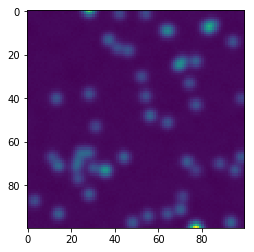

In [17]:
plt.imshow(signal[7])

In [ ]:
spots